# U-Net (圖像分割網路)

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import concatenate, Conv2D, MaxPool2D, Dropout, Conv2DTranspose, UpSampling2D
from tensorflow.keras.activations import relu
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomNormal
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import random

## 定義數據生成器，訓練時用以節省內存

參考自TensorFlow官方文檔

In [0]:
class DataGen(tf.keras.utils.Sequence):
    
    def __init__(self, ids, batch_size=8, image_size=128):
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
    
    # 定義資料讀取方式
    def __load__(self, id_name):
        # 資料路徑
        image_path = f'/content/data/images/image_{id_name}.jpg'
        mask_path = f'/content/data/masks/mask_{id_name}.jpg'
        
        # 讀取圖片以及遮罩
        image = cv.imread(image_path, 1)
        image = cv.resize(image, (self.image_size, self.image_size))
        mask = cv.imread(mask_path, -1)
        mask = np.expand_dims(mask, axis=-1)
            
        # 標準化資料
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    # 生成每個批次數據
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    # 每一次epoch結束時直接進入下一次epoch
    def on_epoch_end(self):
        pass
    
    # 計算每個批次的迭代次數
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## 設定基礎參數

In [0]:
# 原始圖像維度:(128,128,3), 遮罩維度:(128,128,1)
image_size = 128
epochs = 5
batch_size = 8

seed = 2020
random.seed = seed
np.random.seed = seed
tf.seed = seed

ids = [i for i in range(670)]

## 將資料分為訓練集、驗證集以及測試集三部分

In [0]:
val_data_size = 10
test_data_size = 10
total_len = len(ids)
valid_ids = ids[:val_data_size]
train_ids = ids[val_data_size:(total_len-test_data_size)]
test_ids = ids[(total_len-test_data_size):]

## 首先稍微檢視一下資料
### 下圖中，左邊是原始圖片，右邊為遮罩，也就是希望分割出的結果。

In [6]:
gen = DataGen(ids, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


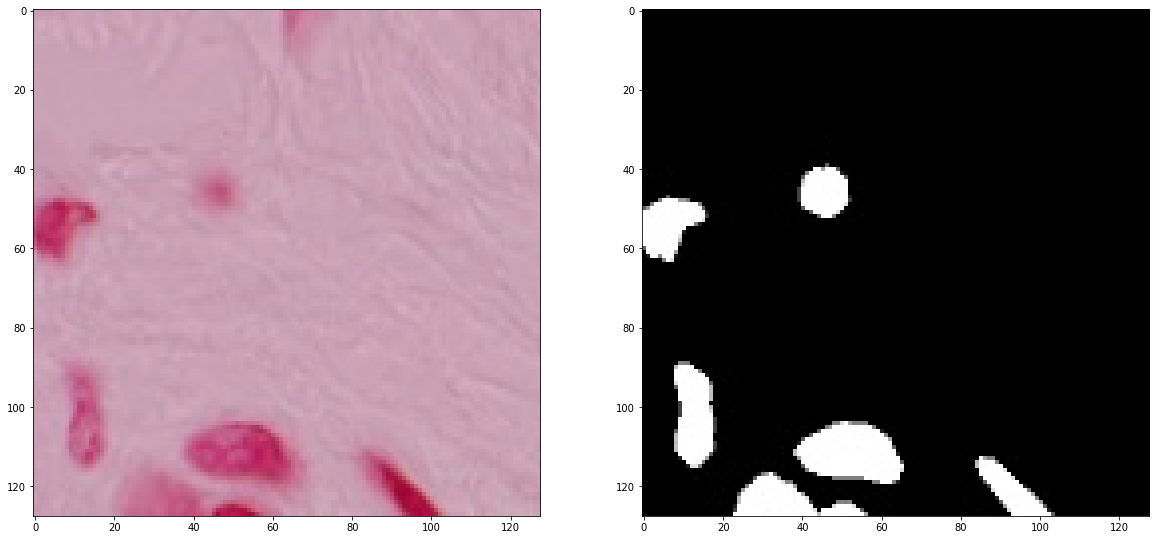

In [7]:
r = random.randint(0, len(x)-1)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## 建構U-Net

下圖為U-Net的網路架構，在此以程式碼逐步建構

In [0]:
def unet(input_shape):
    
    # 定義下採樣層，與傳統CNN相似
    def conv_block(layer, filters):
        conv1 = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(layer)
        conv2 = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(conv1)
        pool = MaxPool2D(2)(conv2)
        return conv2, pool
    
    # 過渡層
    def bottle_neck(layer, filters):
        conv1 = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(layer)
        conv2 = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(conv1)
        drop = Dropout(0.5)(conv2)
        return drop
    
    # 定義上採樣層，並使用跳躍連結(下圖中的灰色箭頭)，傳遞圖像特徵值
    def up_block(layer, filters, concat_layer1):
        deconv = Conv2DTranspose(filters, 2, strides=(2,2), padding='same', activation='relu', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(layer)
        concat = concatenate([concat_layer1, deconv], axis=-1)
        conv1 = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(concat)
        conv2 = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(conv1)
        return conv2
    
    # 開始建構
    img = Input(shape=(input_shape), name='input_image')
    conv1, pool1 = conv_block(img, 64)
    conv2, pool2 = conv_block(pool1, 128)
    conv3, pool3 = conv_block(pool2, 256)
    conv4, pool4 = conv_block(pool3, 512)
    bn = bottle_neck(pool4, 1024)
    up1 = up_block(bn, 512, conv4)
    up2 = up_block(up1, 256, conv3)
    up3 = up_block(up2, 128, conv2)
    up4 = up_block(up3, 64, conv1)
    out = Conv2D(1, 1, activation = 'sigmoid')(up4)
        
    return Model(inputs=img, outputs=out)

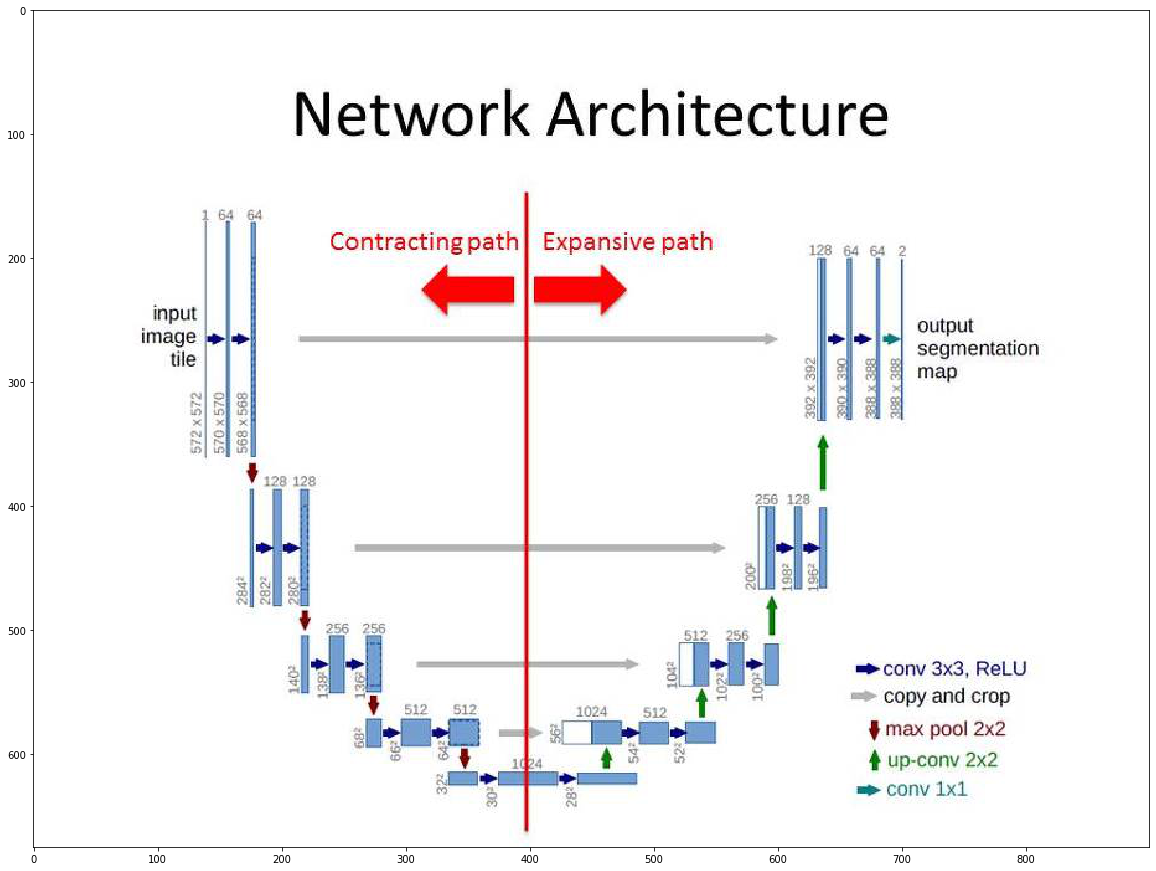

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread('unet architecture.jpg'))

## 定義訓練集、驗證集以及測試集的資料生成器

In [0]:
train_gen = DataGen(train_ids, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, image_size=image_size, batch_size=batch_size)
test_gen = DataGen(test_ids, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

## 訓練模型

訓練時使用model.fit_generator配合數據生成器以節省內存

優化器選用Adam，學習率設定0.0001，
損失函數使用 binary_crossentropy

由於資料量僅有670筆，因此只將模型作初步訓練。

In [0]:
model = unet((128,128,3))

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.fit_generator(train_gen, validation_data=valid_gen, 
                    steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
81/81 [==============================] - 15s 185ms/step - loss: 0.5999 - accuracy: 0.7392 - val_loss: 0.4545 - val_accuracy: 0.7175
Epoch 2/5
81/81 [==============================] - 7s 85ms/step - loss: 0.3666 - accuracy: 0.7503 - val_loss: 0.2117 - val_accuracy: 0.8185
Epoch 3/5
81/81 [==============================] - 7s 85ms/step - loss: 0.3086 - accuracy: 0.7556 - val_loss: 0.1383 - val_accuracy: 0.8185
Epoch 4/5
81/81 [==============================] - 7s 85ms/step - loss: 0.2620 - accuracy: 0.7460 - val_loss: 0.1257 - val_accuracy: 0.8515
Epoch 5/5
81/81 [==============================] - 7s 85ms/step - loss: 0.2365 - accuracy: 0.7653 - val_loss: 0.1496 - val_accuracy: 0.8252


In [0]:
## 以測試資料測試模型成效

In [0]:
x_test, y_test = test_gen.__getitem__(0)
prediction = model.predict(x_test)

## 下圖中，左半部為U-Net分割的結果，右半部為遮罩
### 可以看到物件都有被成功分割，僅邊緣部分較為模糊

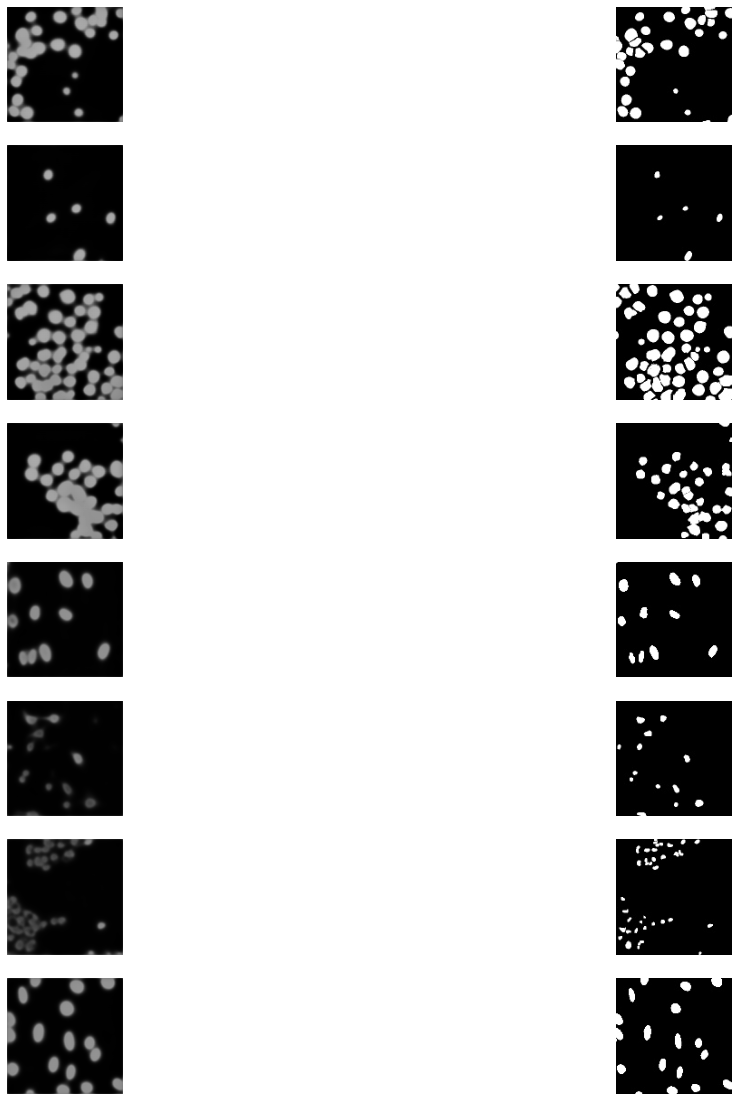

In [14]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(8, 2, i+1)
    if i%2 == 0:
        plt.imshow(prediction[int(i/2)].reshape(128,128), cmap='gray', vmin=0., vmax=1.)
    else:
        plt.imshow(y_test[int(i//2)].reshape(128,128), cmap='gray', vmin=0., vmax=1.)

    plt.axis("off")
plt.show()

# 參考資料

1. TensorFlow官方文檔:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
2. https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
3. https://kknews.cc/tech/6aqgyzl.html
4. https://blog.csdn.net/Formlsl/article/details/80373200
5. https://zhuanlan.zhihu.com/p/65398511
6. Stanford University School of Engineering [Lecture 11 | Detection and Segmentation] https://www.youtube.com/watch?v=nDPWywWRIRo